In [114]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LogNorm
import colorsys
import os
import imageio
import re
import itertools
import pandas as pd
import csv
import time
import plotly.graph_objects as go
plt.rcParams.update({'font.size': 18})

# Evolution functions

In [104]:
def network_evolution(state, t, W, alpha, omega, coupled_neuron, inputn):
    """
    Computes the derivatives of system parameters (densities and phases)
    
    :param state: np.array, vector of densities and phases (rho_1, rho_2, ..., rho_n, theta_1, ..., theta_n)
    :param t: float, current time
    :param W: np.array coupling matrix
    :param alpha: float, constant parameter
    :param omega: np.array, vector of frequencies
    :return: np.array, derivatives of state (input like)
    """
    N = int(len(state)/2)
    dstate_dt = np.zeros_like(state)
    coupled_values_den = state[coupled_neuron]
    coupled_values_phase = state[N+coupled_neuron]
    for neuron in range(N):
        if neuron in inputn: # evolves densities only for input neurons
            #dden_dt = -alpha*state[neuron]*state[neuron]*state[neuron]
            #dden_dt += np.sum(W[neuron]*coupled_values_den*np.cos(coupled_values_phase-state[N+neuron]))
            dden_dt = 0
            dstate_dt[neuron] = dden_dt
            dstate_dt[N+neuron] = 0
        else:
            dden_dt = -alpha*state[neuron]*state[neuron]*state[neuron]
            dden_dt += np.sum(W[neuron]*coupled_values_den*np.cos(coupled_values_phase-state[N+neuron]))

            dphase_dt = omega[neuron] + np.sum(W[neuron]*coupled_values_den/state[neuron]*np.sin(coupled_values_phase-state[N+neuron]))

            dstate_dt[neuron] = dden_dt
            dstate_dt[N+neuron] = dphase_dt
    return dstate_dt

def network_evolution_nudge(state, t, W, alpha, omega, coupled_neuron, inputn, beta_den, beta_phase, target):
    """
    Computes the derivatives of system parameters (densities and phases) after nudge of dynamics
    
    :param state: np.array, vector of densities and phases (rho_1, rho_2, ..., rho_n, theta_1, ..., theta_n)
    :param t: float, current time
    :param W: np.array coupling matrix
    :param alpha: float, constant parameter
    :param omega: np.array, vector of frequencies
    :param beta_den: np.array, density nudge strength (zeros differentiate from output)
    :param beta_phase: np.array, phase nudge strength (zeros differentiate from output)
    :param target: np.array, target state
    :return: np.array, derivatives of state (input like)
    """
    N = int(len(state)/2)
    dstate_dt = np.zeros_like(state)
    coupled_values_den = state[coupled_neuron]
    coupled_values_phase = state[N+coupled_neuron]
    for neuron in range(N):
        if neuron in inputn:
            #dden_dt = -alpha*state[neuron]*state[neuron]*state[neuron]
            #dden_dt += np.sum(W[neuron]*coupled_values_den*np.cos(coupled_values_phase-state[N+neuron]))
            dden_dt = 0
            dstate_dt[neuron] = dden_dt
            dstate_dt[N+neuron] = 0
        else:
            dden_dt = -alpha*state[neuron]*state[neuron]*state[neuron]
            dden_dt += np.sum(W[neuron]*coupled_values_den*np.cos(coupled_values_phase-state[N+neuron]))
            dden_dt += - beta_den[neuron]*(state[neuron]-target[neuron])

            dphase_dt = omega[neuron] + np.sum(W[neuron]*coupled_values_den/state[neuron]*np.sin(coupled_values_phase-state[N+neuron]))
            dphase_dt += - beta_phase[neuron]*np.sin(state[N+neuron]-target[N+neuron])/(np.cos(state[N+neuron]-target[N+neuron])+1+1e-8)

            dstate_dt[neuron] = dden_dt
            dstate_dt[N+neuron] = dphase_dt 
    return dstate_dt

def save_array_to_file(array, filename="savepoint.txt"):
    """
    Appends a numpy array as a new line in a specified file.
    """
    with open(filename, "a") as file:
        # Convert the array to a string representation and append a newline
        file.write(" ".join(map(str, array.flatten())) + "\n")

def read_and_plot(filename="savepoint.txt", x_range=(0, 200), y_bins=50, x_bins=200, y_max=5, plot_title="", save_figure=True):
    """
    Reads arrays from a file, accumulates counts in 2D bins, and plots as a binplot.
    The y-axis is limited to either 5 or the highest y value in the data, whichever is lower.
    
    Parameters:
    - filename (str): The name of the file to read data from.
    - x_range (tuple): The range of x-axis values for binning.
    - y_bins (int): The number of bins along the y-axis.
    - x_bins (int): The number of bins along the x-axis.
    - y_max (float): The maximum y value limit.
    - plot_title (str): The title for the plot.
    - save_figure (bool): Whether to save the plot as an image file.
    """
    # Initialize lists to accumulate all x and y values across arrays
    all_x = []
    all_y = []
    
    with open(filename, "r") as file:
        for line in file:
            # Convert the line to a numpy array of y-values
            y_array = np.array([float(num) for num in line.strip().split()])
            
            # Assuming x array is a sequence (0, 1, ..., len(y_array)-1) for each y_array
            x_array = np.arange(len(y_array))
            
            # Append these x and y values to the lists
            all_x.extend(x_array)
            all_y.extend(y_array)
    
    # Determine the effective maximum y limit
    actual_y_max = min(max(all_y), y_max)
    print(f"The effective y-axis maximum is set to: {actual_y_max}")
    
    # Compute the 2D histogram of counts, limiting y values to [min(all_y), actual_y_max]
    counts, xedges, yedges = np.histogram2d(
        all_x, all_y, bins=[x_bins, y_bins], range=[x_range, (min(all_y), actual_y_max)]
    )
    
    # Plot the resulting bin counts as a heatmap
    plt.figure(figsize=(8, 6))
    plt.title(plot_title)
    plt.imshow(counts.T, origin='lower', aspect='auto', cmap="viridis", 
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.colorbar(label="Point Count")
    plt.ylim(yedges[0], yedges[-1])  # Set y-axis limit to effective maximum
    plt.xlabel("epoch")  # Blank x-axis label
    plt.ylabel("value")  # Blank y-axis label
    
    # Calculate and plot the mean line
    unique_x = np.unique(all_x)
    mean_y_values = [np.mean([y for x, y in zip(all_x, all_y) if x == ux]) for ux in unique_x]
    plt.plot(unique_x, mean_y_values, color='white', linewidth=2, label='Mean Value')

    # Save the figure if requested
    if save_figure and plot_title:
        plt.savefig(f"{plot_title}.png", bbox_inches='tight')
        print(f"Figure saved as: {plot_title}.png")
    
    # Show the plot
    plt.show()


def read_and_plot_log(filename="savepoint.txt", x_range=(0, 200), y_bins=50, x_bins=200, y_max=5, plot_title="", save_figure=True, multiplicator=1):
    """
    Reads arrays from a file, accumulates counts in 2D bins, and plots as a binplot.
    The y-axis is limited to either 5 or the highest y value in the data, whichever is lower.
    
    Parameters:
    - filename (str): The name of the file to read data from.
    - x_range (tuple): The range of x-axis values for binning.
    - y_bins (int): The number of bins along the y-axis.
    - x_bins (int): The number of bins along the x-axis.
    - y_max (float): The maximum y value limit.
    - plot_title (str): The title for the plot.
    - save_figure (bool): Whether to save the plot as an image file.
    """
    # Initialize lists to accumulate all x and y values across arrays
    all_x = []
    all_y = []
    
    # Track the maximum length of y arrays for setting up x-axis
    length_y = 0

    with open(filename, "r") as file:
        for line in file:
            # Convert the line to a numpy array of y-values
            y_array = np.array([float(num) for num in line.strip().split()])*multiplicator
            length_y = max(length_y, len(y_array))  # Update the length_y if this y_array is longer
            
            # Assuming x array is a sequence (0, 1, ..., len(y_array)-1) for each y_array
            x_array = np.arange(len(y_array))
            
            # Append these x and y values to the lists
            all_x.extend(x_array)
            all_y.extend(y_array)
    
    # Set up the x and y bins
    x_space = np.linspace(0, length_y, x_bins + 1)
    
    # Determine the effective maximum y limit
    actual_y_max = min(max(all_y), y_max)
    y_space = np.logspace(np.log10(min(all_y)), np.log10(actual_y_max), y_bins + 1)
    print(f"The effective y-axis maximum is set to: {actual_y_max}")
    
    # Compute the 2D histogram of counts
    counts, xedges, yedges = np.histogram2d(
        all_x, all_y, bins=[x_space, y_space], range=[x_range, (min(all_y), actual_y_max)]
    )
    
    # Plot the resulting bin counts as a heatmap
    plt.figure(figsize=(8, 6))
    plt.hist2d(all_x, all_y, bins=(x_space, y_space), cmap="viridis")
    plt.colorbar(label="Point Count")  # Linear color bar
    plt.yscale('log')
    plt.title(plot_title)
    plt.xlabel("Epoch")
    plt.ylabel("Value (log scale)")
    
    # Calculate and plot the mean line
    unique_x = np.unique(all_x)
    mean_y_values = [np.mean([y for x, y in zip(all_x, all_y) if x == ux]) for ux in unique_x]
    plt.plot(unique_x, mean_y_values, color='white', linewidth=2, label='Mean Value')
    
    # Save the figure if requested
    if save_figure and plot_title:
        plt.savefig(f"{plot_title}.svg", bbox_inches='tight', format='svg')
        print(f"Figure saved as: {plot_title}.svg")
    
    # Show the plot
    plt.show()


# This function reads the arrays from the file, sums them, and plots the resulting binplot.

def find_amplitude_relative(N, neurons, weights, accuracy):
    amplitude_relative = 1
    
    T = 200
    dt = 0.01
    times = np.arange(0, T + dt, dt)
    alpha = 1.
    omega = np.zeros(N)

    # Placeholder to collect mean densities for each solution
    mean_densities = []

    # Step 1: Run 40 evolutions with random initialization
    for i in range(10):
        init_densities = np.array([np.random.uniform(-1, 1) / 2 for _ in neurons]) + amplitude_relative
        init_phases = np.array([np.random.uniform(-np.pi, np.pi) for _ in neurons])
        state = np.concatenate((init_densities, init_phases))

        # Solve the ODE to get the solution
        solution = odeint(network_evolution, state, times, args=(weights, alpha, omega, connections_neuronwise, inputn), full_output=0)
        
        # Collect the mean density for this solution (mean of first N elements)
        densities = solution[:, :N]
        mean_density = np.mean(densities)
        mean_densities.append(mean_density)

    # Step 2: Calculate the mean density value of mean densities
    overall_mean_density = np.mean(mean_densities)

    # Step 3 & 4: Iterate based on "accuracy" value
    for _ in range(accuracy):
        # Update labels_amp and features_amps based on the current amplitude_relative
        labels_amp = np.array([-1, 1, 1, -1]) / 2 + amplitude_relative
        features_amps = np.array([
            [-1, -1],
            [1, -1],
            [-1, 1],
            [1, 1]
        ]) / 2 + amplitude_relative

        for feature_amp in features_amps:
            # Distribute using feature_amp with distribution 0.5 around the mean point
            init_densities = np.array([np.random.uniform(-0.5, 0.5) for _ in neurons]) + overall_mean_density
            init_densities[0] = feature_amp[0]  # Set init_densities[0] to corresponding value of features_amps
            init_densities[1] = feature_amp[1]  # Set init_densities[1] to corresponding value of features_amps
            init_phases = np.array([np.random.uniform(-np.pi, np.pi) for _ in neurons])
            state = np.concatenate((init_densities, init_phases))

            # Step 5: Run 10 evolutions to refine the mean amplitude_relative
            for _ in range(3):
                solution = odeint(network_evolution, state, times, args=(weights, alpha, omega, connections_neuronwise, inputn), full_output=0)
                densities = solution[:, :N]
                mean_density = np.mean(densities)

                # Update amplitude_relative based on new mean_density
                amplitude_relative = mean_density
                
    return features_amps, labels_amp, amplitude_relative


def run_from_nothing(N=5, number_of_epochs=300, learning_rate=0.1, do_normalize=False, do_debug=False, connections_neuronwise=None, amplitude_relative=None, randomization=1):

    # preamble
    neurons = np.arange(0,N,1) 
    outputn = 2 
    inputn = [0,1] 
    if connections_neuronwise==None:
        connections_neuronwise = np.array([[element for element in neurons if element != neuron] for neuron in neurons]) 

    weights_matrix = np.zeros((N,N)) 
    for i in range(1,N):
        for j in range(0,i):
            weights_matrix[i][j] = np.random.normal(loc=0, scale=1)
            weights_matrix[j][i] = weights_matrix[i][j]
    weights = weights_matrix[connections_neuronwise, np.arange(N)[:, None]] 
    alpha = 1. 
    omega = np.zeros(N) 

    gradient_weights_forward = np.zeros((N,N))
    gradient_weights_backward = np.zeros((N,N))
    weight_gradient = np.zeros((N,N))

    beta_den = np.zeros(N)
    beta_den[outputn] = 1e-6

    batch_size = 4
    random_init_times = 1
    inv_nudge_step_den = 1/beta_den[outputn]
    inv_batch_size = 1/batch_size
    inv_random_init_times = 1/randomization

    if amplitude_relative==None:
        features_amp, labels_amp, amplitude_relative = find_amplitude_relative(N, neurons, weights, 2)
    else:
        features_amp = np.array([
        [-1,-1],
        [1,-1],
        [-1,1],
        [1,1]
        ])/2 + amplitude_relative
        labels_amp = np.array([-1,1,1,-1])/2 + amplitude_relative 

    T = 200
    dt = 0.01
    times = np.arange(0, T+dt, dt)

    init_densities = np.array([np.random.uniform(-1, 1)/2 for _ in neurons]) + amplitude_relative
    init_phases = np.array([np.random.uniform(-np.pi, np.pi) for _ in neurons])

    state = np.concatenate((init_densities, init_phases))

    distances_amp = []
    accuracies = []

    # training loop

    for epoch in range(number_of_epochs):
        for _ in range(randomization):
            time0 = time.time()
            if epoch%10 == 0:
                print(f"Starting epoch number {epoch}")

            weight_gradient = np.zeros((N,N))
            
            distance_amp_temp = []
            accuracies_temp = []
            for feature_amp, label_amp in zip(features_amp, labels_amp):
                
                target = np.zeros(2*N)
                target[outputn] = label_amp

                densities = np.copy(init_densities)
                phases = np.array([np.random.uniform(-np.pi, np.pi) for _ in neurons])
                densities[inputn[0]] = feature_amp[0]
                densities[inputn[1]] = feature_amp[1]
                state = np.concatenate((densities, phases))

                # calculating inference and inference energy
                states = odeint(network_evolution, state, times, args=(weights, alpha, omega, connections_neuronwise, inputn), full_output=0)

                phases = states[-1][N:2*N]
                densities = states[-1][0:N]
                state = np.concatenate((densities, phases)) # I forgot to add this before, checking solution requires attention to this detail

                # calculating distance and cost
                distance_amp_temp.append(np.abs(densities[outputn]-label_amp))
                if label_amp > amplitude_relative:
                    accuracies_temp.append(densities[outputn]>amplitude_relative)
                else:
                    accuracies_temp.append(densities[outputn]<amplitude_relative)

                # calculating for mean values (in case of oscillations or other symmetric events)
                #phases = np.mean([state[N:2*N] for state in states], axis=0)
                #densities = np.mean([state[0:N] for state in states], axis=0)

                # calculating energy gradient over weights
                for i in range(1,N):
                    for j in range(0,i):
                        gradient_weights_forward[i][j] = -densities[i]*densities[j]*np.cos(phases[i]-phases[j])
                        gradient_weights_forward[j][i] = gradient_weights_forward[i][j]
                
                # calculating nudge of inference and its energy
                states_back = odeint(network_evolution_nudge, state, times, args=(weights, alpha, omega, connections_neuronwise, inputn, beta_den, beta_phase, target), full_output=0)

                phases = states_back[-1][N:2*N]
                densities = states_back[-1][0:N]

                #phases = np.mean([state[N:2*N] for state in states_back], axis=0)
                #densities = np.mean([state[0:N] for state in states_back], axis=0)

                for i in range(1,N):
                    for j in range(0,i):
                        gradient_weights_backward[i][j] = -densities[i]*densities[j]*np.cos(phases[i]-phases[j])
                        gradient_weights_backward[j][i] = gradient_weights_backward[i][j]
                
                # calculating gradient
                weight_gradient += gradient_weights_backward - gradient_weights_forward
            # test_grad_vals.append(np.linalg.norm(gradient_weights_backward - gradient_weights_forward,ord=1))
        time1 = time.time()
        weight_gradient *= inv_batch_size*inv_random_init_times*inv_nudge_step_den
        distances_amp.append(np.sum(distance_amp_temp)/batch_size)
        accuracies.append(np.sum(accuracies_temp)/batch_size)

        # parameter updates
        #weight_gradient *= (inv_nudge_step_den+inv_nudge_step_phase) * inv_batch_size * inv_random_init_times

        # normalization (required for first few steps)
        
        #if np.linalg.norm(weight_gradient, ord=2)>5:
        if do_debug: 
            print(f"epoch {epoch},\ttime elapsed: {time1-time0}, gradient size {np.linalg.norm(weight_gradient,ord=1)}")
        if time1-time0>10:
            print("time exceeded critical amount")
            break
        if do_normalize: #np.linalg.norm(weight_gradient,ord=1) > 1* N*N:
            #print(f"gradient absolute size exceeded expected value\nL(∇W) = {np.linalg.norm(weight_gradient, ord=1)}")
            #print("NORMALIZED!")
            weight_gradient /= np.linalg.norm(weight_gradient,ord=1)
        
        

        weights_matrix -= learning_rate * weight_gradient
        weights = weights_matrix[connections_neuronwise, np.arange(N)[:, None]]

    #do_save = input("Do you want to save the distances and accuracies y/n:\t")
    
    return distances_amp, accuracies

# Network parameters

In [3]:
N = 7 # number of neurons
neurons = np.arange(0,N,1) #
outputn = 2 #output neuron
inputn = [0,1] # input neurons
connections_neuronwise = np.array([[element for element in neurons if element != neuron] for neuron in neurons]) # connections between neurons

weights_matrix = np.zeros((N,N)) # defining weights and initializing for lookup
for i in range(1,N):
    for j in range(0,i):
        weights_matrix[i][j] = np.random.normal(loc=0, scale=1)
        weights_matrix[j][i] = weights_matrix[i][j]
weights = weights_matrix[connections_neuronwise, np.arange(N)[:, None]] # defining weights for direct use
alpha = 1. # defining alpha parameter
omega = np.zeros(N) # defining frequencies (for now 0's)

# Dataset
XOR with:

$0\rightarrow -\pi/2$

$1\rightarrow \pi/2$

for $\theta$ and:

$1.5\rightarrow -1$

$0.5\rightarrow 1$

for $\rho$


In [4]:
amplitude_relative = 1
features_converted = np.array([
        [-np.pi,-np.pi],
        [np.pi,-np.pi],
        [-np.pi,np.pi],
        [np.pi,np.pi]
    ])/2
features_amp = np.array([
    [-1,-1],
    [1,-1],
    [-1,1],
    [1,1]
])/2 + amplitude_relative

labels_converted = np.array([-np.pi,np.pi,np.pi,-np.pi])/2
labels_amp = np.array([-1,1,1,-1])/2 + amplitude_relative 
features_original = np.array([[0,0],[1,0],[0,1],[1,1]])
features_original_label = ["0,0","1,0","0,1","1,1"]
labels_original = np.array([0,1,1,0])

In [55]:
neurons = np.arange(0,N,1) 
outputn = 2 
inputn = [0,1] 
connections_neuronwise = np.array([[element for element in neurons if element != neuron] for neuron in neurons]) 

weights_matrix = np.zeros((N,N)) 
for i in range(1,N):
    for j in range(0,i):
        weights_matrix[i][j] = np.random.normal(loc=0, scale=1)
        weights_matrix[j][i] = weights_matrix[i][j]
weights = weights_matrix[connections_neuronwise, np.arange(N)[:, None]] 
alpha = 1. 
omega = np.zeros(N) 

gradient_weights_forward = np.zeros((N,N))
gradient_weights_backward = np.zeros((N,N))
weight_gradient = np.zeros((N,N))

beta_den = np.zeros(N)
beta_den[outputn] = 1e-6

batch_size = 4
random_init_times = 1
inv_nudge_step_den = 1/beta_den[outputn]
inv_batch_size = 1/batch_size
inv_random_init_times = 1/random_init_times

features_amps, labels_amp, amplitude_relative = find_amplitude_relative(N, neurons, weights, 1)

In [56]:
features_amps, labels_amp, amplitude_relative

(array([[0.5, 0.5],
        [1.5, 0.5],
        [0.5, 1.5],
        [1.5, 1.5]]),
 array([0.5, 1.5, 1.5, 0.5]),
 3.063613510961493)

# Learning parameters and initialization

In [57]:
gradient_weights_forward = np.zeros((N,N))
gradient_weights_backward = np.zeros((N,N))
weight_gradient = np.zeros((N,N))
# holds normalised values of each gradient after 1 inference (used for debugging)
test_grad_vals = []

learning_rate = 0.1

beta_den = np.zeros(N)
beta_phase = np.zeros(N)
# beta den doesn't partake in information processing directly, so respective cost function is ommited
beta_den[outputn] = 1e-6
beta_phase[outputn] = 1e-6

batch_size = 4
random_init_times = 1
if beta_den[outputn] != 0:
    inv_nudge_step_den = 1/beta_den[outputn]
inv_nudge_step_phase = 1/beta_phase[outputn]
inv_batch_size = 1/batch_size
inv_random_init_times = 1/random_init_times

T = 10
dt = 0.02
times = np.arange(0, T+dt, dt)

init_densities = np.array([np.random.uniform(-1, 1)/2 for _ in neurons]) + amplitude_relative
init_phases = np.array([np.random.uniform(-np.pi, np.pi) for _ in neurons])

state = np.concatenate((init_densities, init_phases))

num_of_epochs = 100
distances = []
distances_amp = []
costs = []
costs_amp = []

In [58]:
#state = np.array([10.,20.,30.,40.,50.,11.,12.,13.,14.,15.]) # test array for tests idk
omega = np.zeros(N)
import time
start_time = time.time()
state[0] = 0.5
state[1] = 1.5
revolt = odeint(network_evolution, state, times, args=(weights, alpha, omega, connections_neuronwise, inputn), full_output=0)
end_time = time.time()

operation_time = end_time - start_time
operation_time

0.08023524284362793

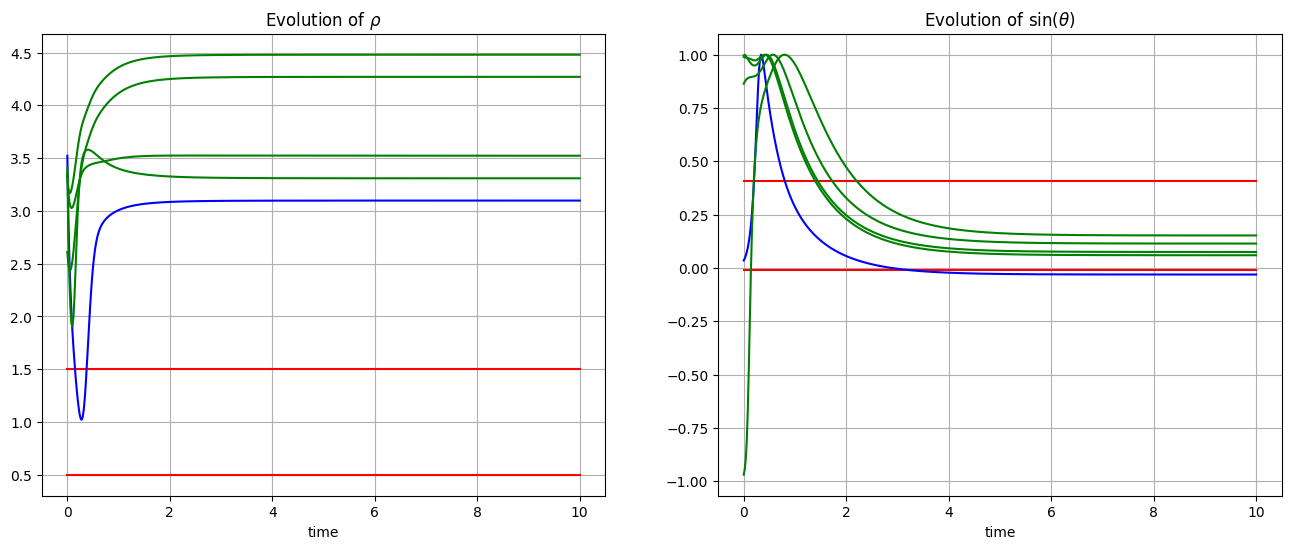

In [59]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 6)) 
colors = ['green'] * N  # Default to green for all indices
colors[inputn[0]] = 'red'
colors[inputn[1]] = 'red'
colors[outputn] = 'blue'
for j in range(N):
    axes[0].plot(times, revolt[:,j], color=colors[j])
axes[0].set_title(r"Evolution of $\rho$")
axes[0].set_xlabel("time")
axes[0].grid()

for j in range(N):
    axes[1].plot(times, np.sin(revolt[:,N+j]), color=colors[j])
axes[1].set_xlabel("time")
axes[1].grid()
axes[1].set_title(r"Evolution of $\sin(\theta)$")
plt.show()

# Inference and learning

In [108]:
T = 200
dt = 0.004
times = np.arange(0, T+dt, dt)

Starting epoch number 0
Starting epoch number 10
Starting epoch number 20
Starting epoch number 30
Starting epoch number 40


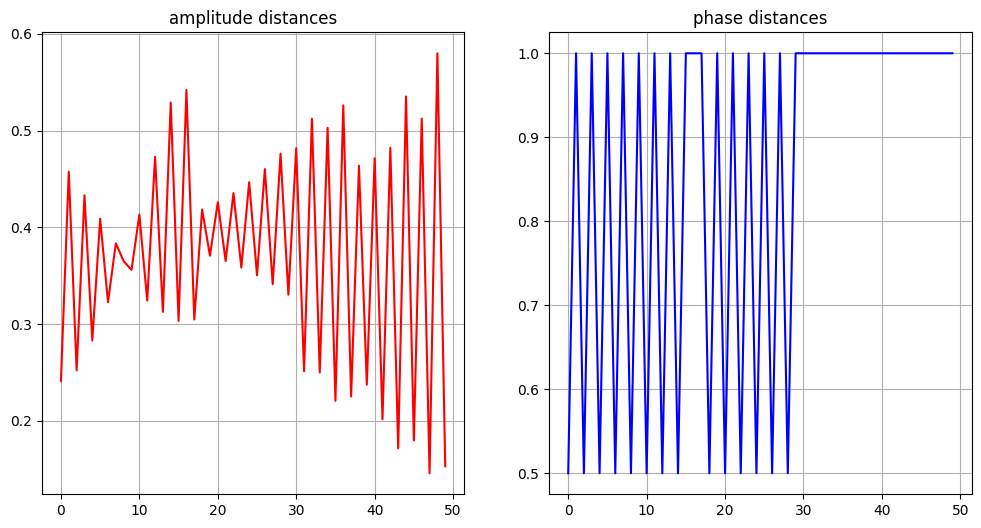

In [109]:
learning_rate = 0.3
num_of_epochs = 50

for epoch in range(num_of_epochs):

    if epoch%10 == 0:
        print(f"Starting epoch number {epoch}")

    weight_gradient = np.zeros((N,N))
    
    distance_temp = []
    distance_amp_temp = []
    cost_temp = []
    cost_amp_temp = []
    for feature, feature_amp, label, label_amp in zip(features_converted, features_amp, labels_converted, labels_amp):
        
        # for now target takes only
        target = np.zeros(2*N)
        target[outputn] = label_amp
        #target[N+outputn] = label

        # inserting input values and random initialization
        #densities = np.array([np.random.uniform(2.8, 3.2) for _ in neurons]) # maybe randomizing densities is wrong habit. To consider them like that I should encode information with them, this way they would be more than mobile parameters
        densities = np.copy(init_densities)
        phases = np.array([np.random.uniform(-np.pi, np.pi) for _ in neurons])
        #phases = np.copy(init_phases)
        densities[inputn[0]] = feature_amp[0]
        densities[inputn[1]] = feature_amp[1]
        phases[inputn[0]] = feature[0]
        phases[inputn[1]] = feature[1]
        state = np.concatenate((densities, phases))

        # calculating inference and inference energy
        states = odeint(network_evolution, state, times, args=(weights, alpha, omega, connections_neuronwise, inputn), full_output=0)

        phases = states[-1][N:2*N]
        densities = states[-1][0:N]
        state = np.concatenate((densities, phases)) # I forgot to add this before, checking solution requires attention to this detail

        # calculating for mean values (in case of oscillations or other symmetric events)
        #phases = np.mean([state[N:2*N] for state in states], axis=0)
        #densities = np.mean([state[0:N] for state in states], axis=0)

        # calculating energy gradient over weights
        for i in range(1,N):
            for j in range(0,i):
                gradient_weights_forward[i][j] = -densities[i]*densities[j]*np.cos(phases[i]-phases[j])
                gradient_weights_forward[j][i] = gradient_weights_forward[i][j]
        
        # calculating nudge of inference and its energy
        states_back = odeint(network_evolution_nudge, state, times, args=(weights, alpha, omega, connections_neuronwise, inputn, beta_den, beta_phase, target), full_output=0)

        phases = states_back[-1][N:2*N]
        densities = states_back[-1][0:N]

        #phases = np.mean([state[N:2*N] for state in states_back], axis=0)
        #densities = np.mean([state[0:N] for state in states_back], axis=0)

        for i in range(1,N):
            for j in range(0,i):
                gradient_weights_backward[i][j] = -densities[i]*densities[j]*np.cos(phases[i]-phases[j])
                gradient_weights_backward[j][i] = gradient_weights_backward[i][j]
        
        # calculating gradient
        weight_gradient += gradient_weights_backward - gradient_weights_forward
        # test_grad_vals.append(np.linalg.norm(gradient_weights_backward - gradient_weights_forward,ord=1))

        # calculating distance and cost
        distance_temp.append(1-np.cos(phases[outputn]-label))
        distance_amp_temp.append(np.abs(densities[outputn]-label_amp))
        cost_temp.append(-np.log(1+np.cos(phases[outputn]-label)))
        cost_amp_temp.append((densities[outputn] - label_amp)*(densities[outputn] - label_amp))
    
    weight_gradient *= inv_batch_size*inv_random_init_times*inv_nudge_step_phase
    distances.append(np.mean(distance_temp))
    distances_amp.append(np.mean(distance_amp_temp))
    costs.append(np.mean(cost_temp))
    costs.append(np.mean(cost_amp_temp))
    test_grad_vals.append(np.linalg.norm(weight_gradient,ord=1)/4)
    # parameter updates
    #weight_gradient *= (inv_nudge_step_den+inv_nudge_step_phase) * inv_batch_size * inv_random_init_times

    # normalization (required for first few steps)
    
    #if np.linalg.norm(weight_gradient, ord=2)>5:
    if True: #np.linalg.norm(weight_gradient,ord=1) > 1* N*N:
        #print(f"gradient absolute size exceeded expected value\nL(∇W) = {np.linalg.norm(weight_gradient, ord=1)}")
        #print("NORMALIZED!")
        weight_gradient /= np.linalg.norm(weight_gradient,ord=1)
 
    

    weights_matrix -= learning_rate * weight_gradient
    weights = weights_matrix[connections_neuronwise, np.arange(N)[:, None]]

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
axes[0].plot(distances_amp, label="amplitude", c="r")
axes[0].set_title("amplitude distances")
axes[0].grid()
axes[1].plot(distances, c="b")
axes[1].set_title("phase distances")
axes[1].grid()
plt.savefig("XOR_SLNN_distances.png")
plt.show()

#do_save = input("Do you want to save the distances and accuracies y/n:\t")
if False:
    append_to_csv("XOR_SLNN_distances.csv", distances)

# Pure inference:

In [102]:
distance_temp = []
distance_amp_temp = []
cost_temp = []
outphase_temp = []
states_temp = []

for feature, feature_amp, label, label_amp in zip(features_converted, features_amp, labels_converted, labels_amp):
    target = np.zeros(2*N)
    target[N+outputn] = label

    # initial randomization
    #densities = np.array([np.random.uniform(0.5, 1.5) for _ in neurons])
    densities = np.copy(init_densities)
    phases = np.array([np.random.uniform(-np.pi, np.pi) for _ in neurons])
    #phases = np.copy(init_phases)
    densities[inputn[0]] = feature_amp[0]
    densities[inputn[1]] = feature_amp[1]
    phases[inputn[0]] = feature[0]
    phases[inputn[1]] = feature[1]
    state = np.concatenate((densities, phases))
    
    states = odeint(network_evolution, state, times, args=(weights, alpha, omega, connections_neuronwise, inputn), full_output=0)

    phases = states[-1][N:2*N]
    densities = states[-1][0:N]

    states_temp.append(states)
    distance_temp.append(1-np.cos(phases[outputn]-label))
    distance_amp_temp.append(np.abs(densities[outputn]-label_amp))
    if phases[outputn]-label == 0:
        cost_temp.append(0)
    else:
        cost_temp.append(-np.log(1+np.cos(phases[outputn]-label)))
    outphase_temp.append(phases[outputn])

/tmp/ipykernel_208444/3955168000.py:33: RuntimeWarning: divide by zero encountered in log
  cost_temp.append(-np.log(1+np.cos(phases[outputn]-label)))


### Output is blue, hidden neurons are green, input neurons are red

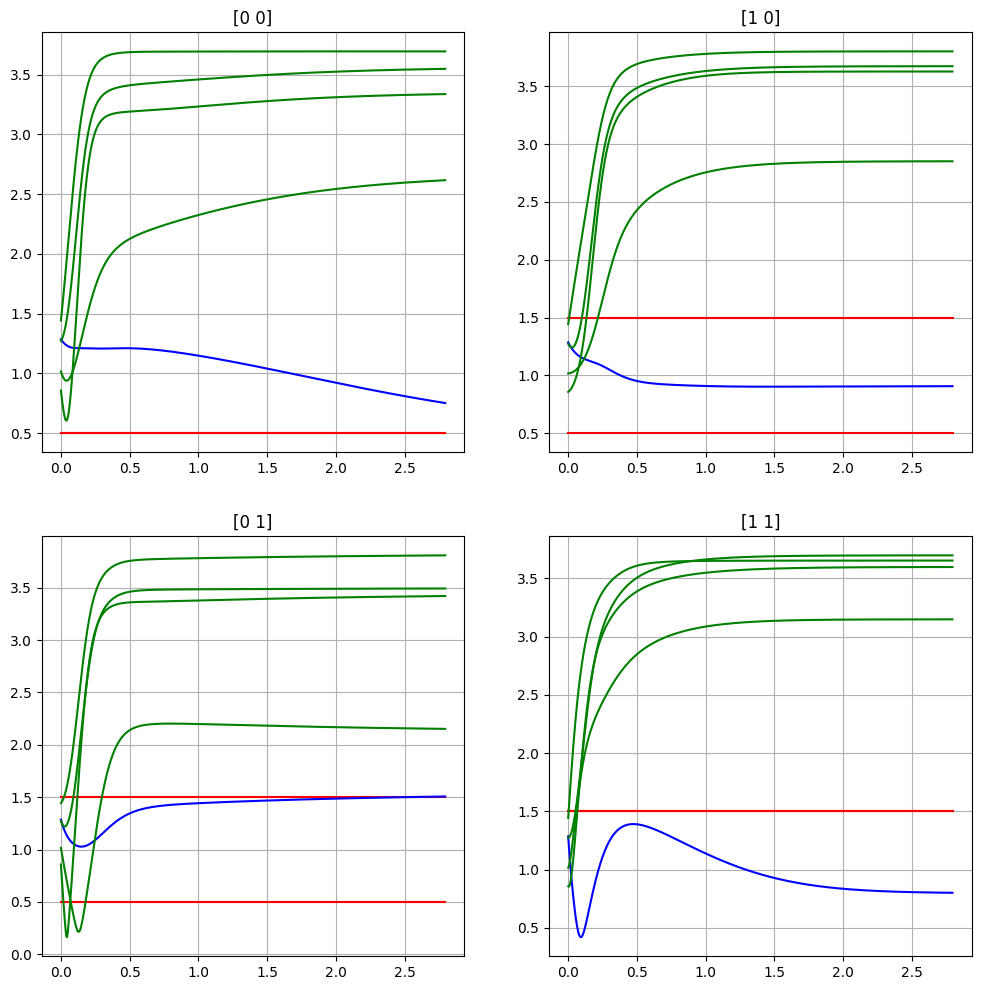

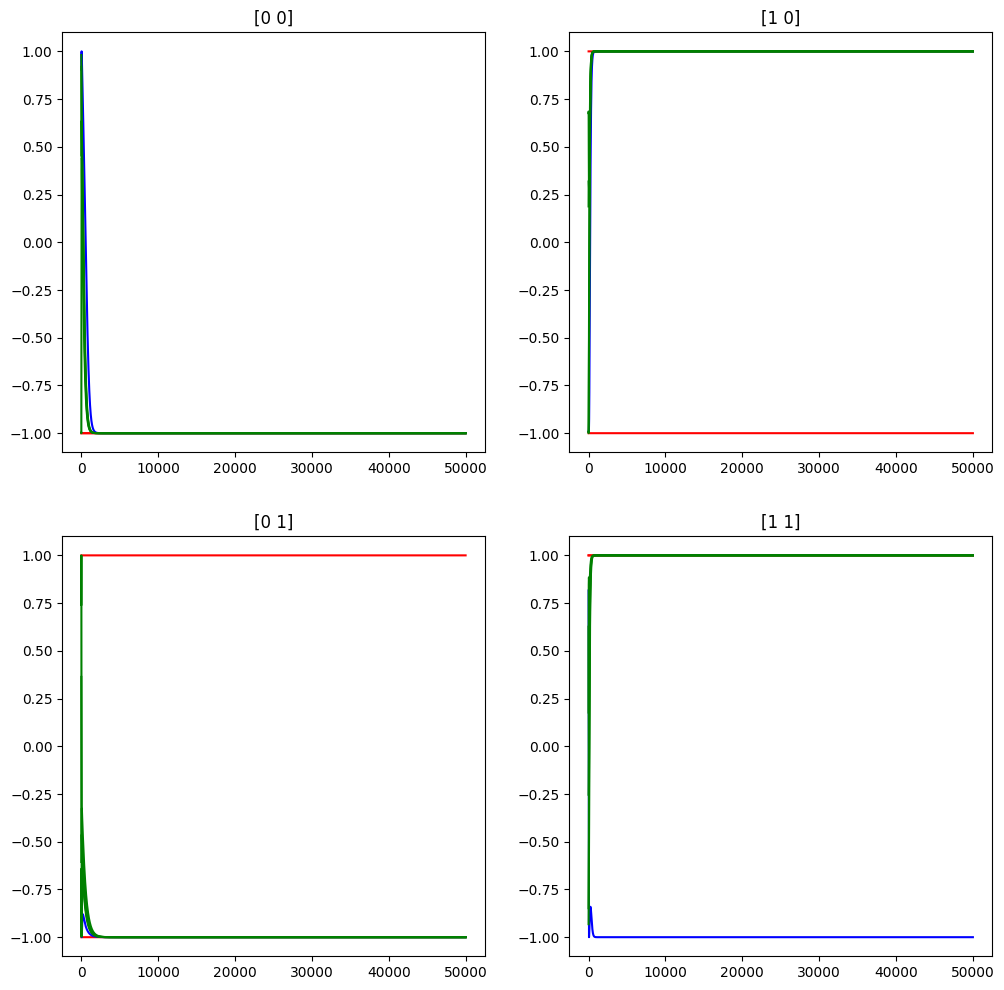

In [177]:
# Densities
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12)) 

for i, ax in enumerate(axes.flatten()):
    # Initialize an array for colors based on indices
    colors = ['green'] * N  # Default to green for all indices
    colors[inputn[0]] = 'red'
    colors[inputn[1]] = 'red'
    colors[outputn] = 'blue'

    # Plot each state with the assigned color
    for j in range(N):
        ax.plot(times[0:700], states_temp[i][:, j][0:700], color=colors[j])
        ax.grid()
    
    ax.set_title(features_original[i])

plt.show()
# Phases
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12)) 

for i, ax in enumerate(axes.flatten()):
    # Initialize an array for colors based on indices
    colors = ['green'] * N  # Default to green for all indices
    colors[inputn[0]] = 'red'
    colors[inputn[1]] = 'red'
    colors[outputn] = 'blue'

    # Plot each sine-transformed state with the assigned color
    for j in range(N):
        ax.plot(np.sin(states_temp[i][:, j + N]), color=colors[j])
    
    ax.set_title(features_original[i])

plt.show()

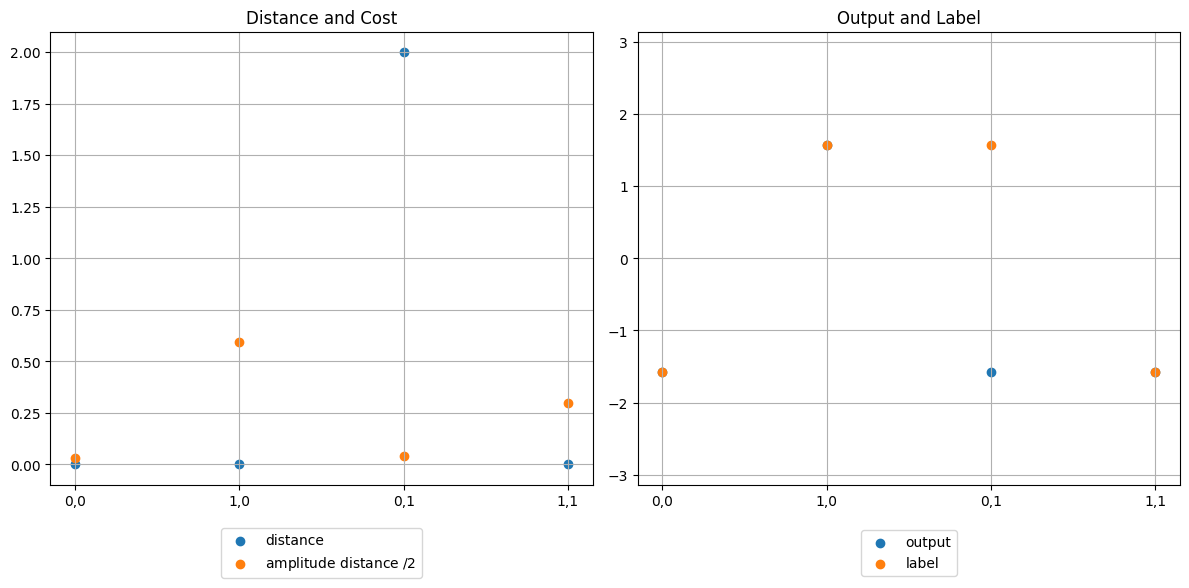

In [104]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))  # Create a figure with two subplots side by side
features_original_label = ["0,0","1,0","0,1","1,1"]
# First subplot (left side)
axes[0].scatter(features_original_label, distance_temp, label="distance")
axes[0].scatter(features_original_label, distance_amp_temp, label="amplitude distance $/2$")
axes[0].legend(loc='center', bbox_to_anchor=(0.5, -0.15))  # Center legend below the plot
axes[0].grid()
axes[0].set_title("Distance and Cost")

# Second subplot (right side)
axes[1].scatter(features_original_label, (np.array(outphase_temp) + np.pi) % (2 * np.pi) - np.pi, label="output")
axes[1].scatter(features_original_label, labels_converted, label="label")
axes[1].set_ylim([-np.pi, np.pi])
axes[1].grid()
axes[1].legend(loc='center', bbox_to_anchor=(0.5, -0.15))  # Center legend below the plot
axes[1].set_title("Output and Label")

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

In [ ]:
"""
for _ in range(40):
        distances_amp, accuracies = run_from_nothing(N=7,number_of_epochs=200, learning_rate=0.1, do_normalize=True, do_debug=True, connections_neuronwise=None, amplitude_relative=1.)
        save_array_to_file(np.array(distances_amp), "XOR_SLNN_distances_7.txt")
        save_array_to_file(np.array(accuracies), "XOR_SLNN_accuracies_7.txt")
for _ in range(40):
        distances_amp, accuracies = run_from_nothing(N=6,number_of_epochs=200, learning_rate=0.1, do_normalize=True, do_debug=True, connections_neuronwise=None, amplitude_relative=1.)
        save_array_to_file(np.array(distances_amp), "XOR_SLNN_distances_6.txt")
        save_array_to_file(np.array(accuracies), "XOR_SLNN_accuracies_6.txt")
"""
for _ in range(20):
        distances_amp, accuracies = run_from_nothing(N=6,number_of_epochs=200, learning_rate=0.1, do_normalize=False, do_debug=False, connections_neuronwise=None, amplitude_relative=1.)
        save_array_to_file(np.array(distances_amp), "XOR_SLNN_distances_6_no_norm.txt")
        save_array_to_file(np.array(accuracies), "XOR_SLNN_accuracies_6_no_norm.txt")
for _ in range(20):
        distances_amp, accuracies = run_from_nothing(N=5,number_of_epochs=200, learning_rate=0.1, do_normalize=True, do_debug=True, connections_neuronwise=None, amplitude_relative=1.)
        save_array_to_file(np.array(distances_amp), "XOR_SLNN_distances_5.txt")
        save_array_to_file(np.array(accuracies), "XOR_SLNN_accuracies_5.txt")

The effective y-axis maximum is set to: 2.1650397610341976
Figure saved as: 5 neurons distances.png


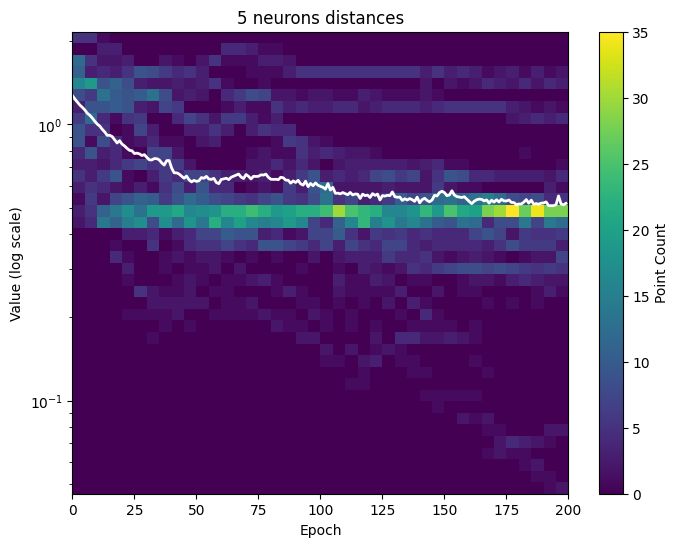

The effective y-axis maximum is set to: 1.0
Figure saved as: 5 neurons, accuracies.png


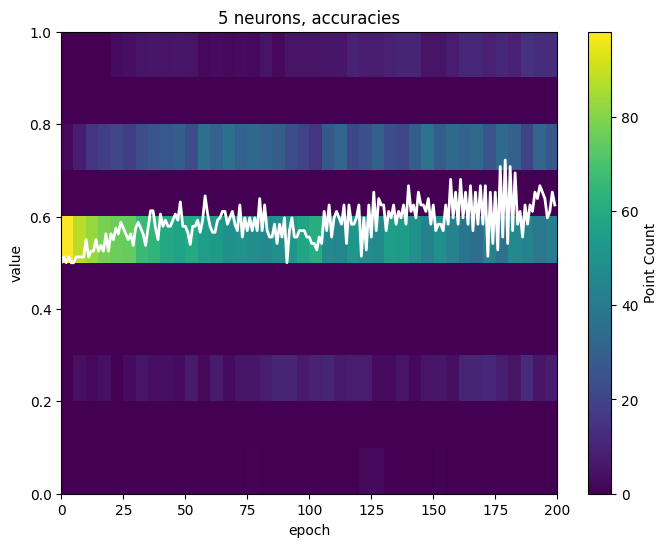

The effective y-axis maximum is set to: 3.5624983821372505
Figure saved as: 6 neurons distances.png


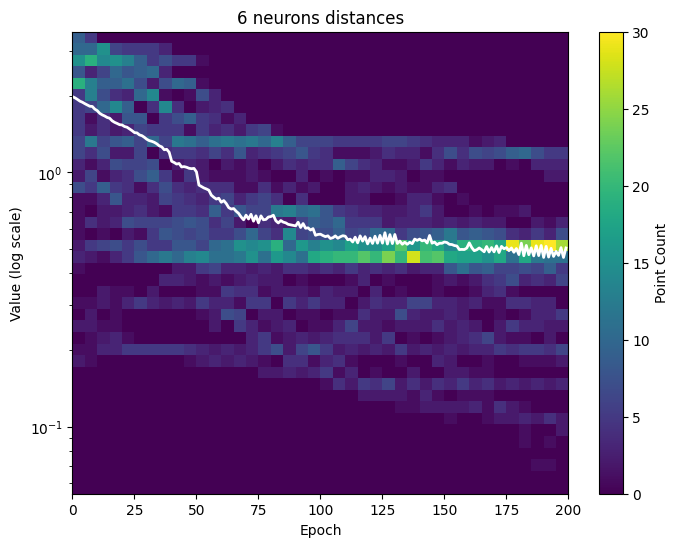

The effective y-axis maximum is set to: 1.0
Figure saved as: 6 neurons accuracies.png


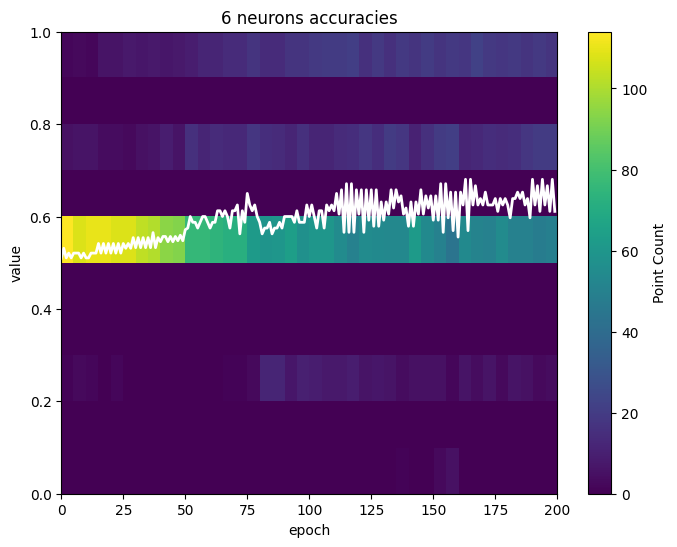

The effective y-axis maximum is set to: 5
Figure saved as: 6 neurons (no norm) distances.png


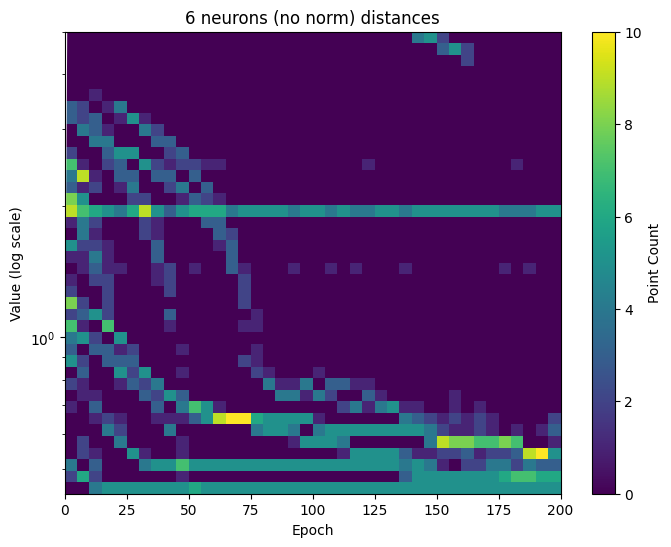

The effective y-axis maximum is set to: 0.75
Figure saved as: 6 neurons (no norm) accuracies.png


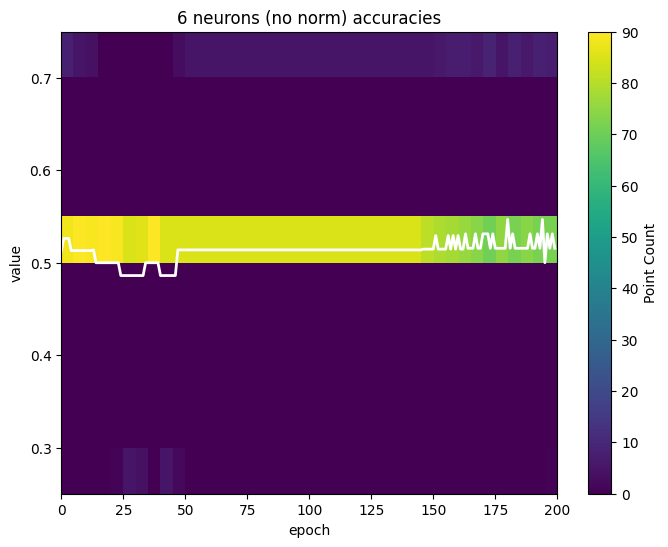

The effective y-axis maximum is set to: 4.314417563013295
Figure saved as: 7 neurons distances.png


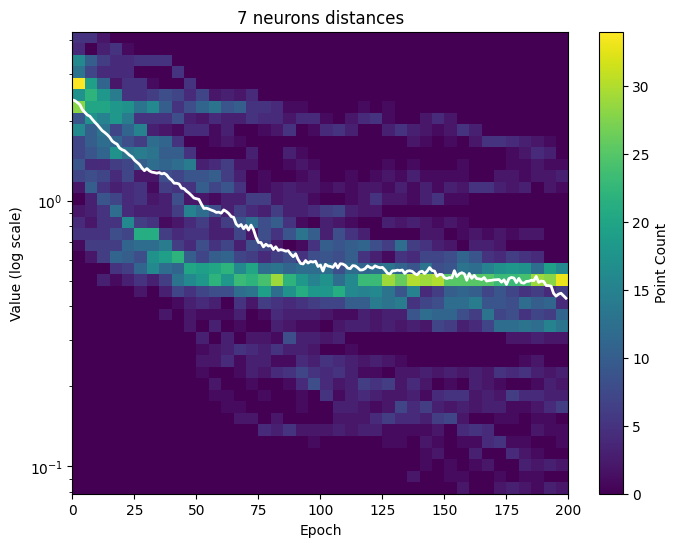

The effective y-axis maximum is set to: 1.0
Figure saved as: 7 neurons accuracies.png


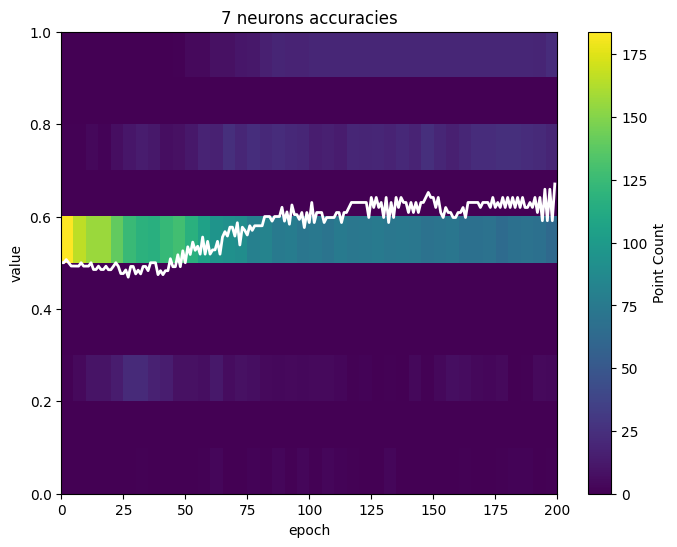

In [145]:
read_and_plot_log("XOR_SLNN_distances_5.txt", y_bins=40, x_bins=40, plot_title="5 neurons distances")
read_and_plot("XOR_SLNN_accuracies_5.txt", y_bins=10, x_bins=40, plot_title="5 neurons, accuracies")
read_and_plot_log("XOR_SLNN_distances_6.txt", y_bins=40, x_bins=40, plot_title="6 neurons distances")
read_and_plot("XOR_SLNN_accuracies_6.txt", y_bins=10, x_bins=40, plot_title="6 neurons accuracies")
read_and_plot_log("XOR_SLNN_distances_6_no_norm.txt", y_bins=40, x_bins=40, plot_title="6 neurons (no norm) distances")
read_and_plot("XOR_SLNN_accuracies_6_no_norm.txt", y_bins=10, x_bins=40, plot_title="6 neurons (no norm) accuracies")
read_and_plot_log("XOR_SLNN_distances_7.txt", y_bins=40, x_bins=40, plot_title="7 neurons distances")
read_and_plot("XOR_SLNN_accuracies_7.txt", y_bins=10, x_bins=40, plot_title="7 neurons accuracies")

x_space: [  0.           6.89655172  13.79310345  20.68965517  27.5862069
  34.48275862  41.37931034  48.27586207  55.17241379  62.06896552
  68.96551724  75.86206897  82.75862069  89.65517241  96.55172414
 103.44827586 110.34482759 117.24137931 124.13793103 131.03448276
 137.93103448 144.82758621 151.72413793 158.62068966 165.51724138
 172.4137931  179.31034483 186.20689655 193.10344828 200.        ]
y_space: [0.04601702 0.0525524  0.06001593 0.06853945 0.07827348 0.08938995
 0.1020852  0.11658343 0.13314071 0.15204947 0.17364367 0.1983047
 0.22646811 0.25863131 0.29536236 0.33730999 0.38521505 0.43992364
 0.50240198 0.57375356 0.65523855 0.74829611 0.85456979 0.97593656
 1.11453994 1.27282789 1.45359604 1.66003705 1.89579699 2.16503976]


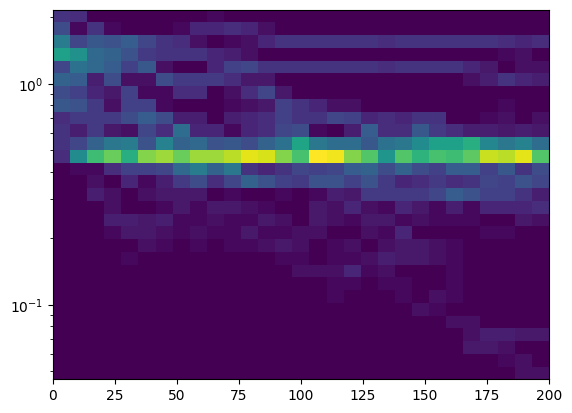

In [79]:
y_max = 5

X = []
Y = []
length_y=0
with open("XOR_SLNN_distances_5.txt", "r") as file:
    for line in file:
        # Convert the line to a numpy array of y-values
        y_array = np.array([float(num) for num in line.strip().split()])
        length_y = max(length_y, len(y_array))  # Update the length_y if this y_array is longer
        
        # Assuming x array is a sequence (0, 1, ..., len(y_array)-1) for each y_array
        x_array = np.arange(len(y_array))
        
        # Append these x and y values to the lists
        X.extend(x_array)
        Y.extend(y_array)
X = np.array(X)
Y = np.array(Y)
#X = np.random.normal(30, 10, 1000)
#Y = np.random.normal(200, 500, 1000)

x_space = np.linspace(0, length_y, 30)
print('x_space:', x_space)

actual_y_max = min(max(Y), y_max)
y_space = np.logspace(np.log10(min(Y)), np.log10(actual_y_max), 30)
print('y_space:', y_space)

plt.hist2d(X, Y, bins=(x_space, y_space))
plt.yscale('log')
plt.show()

# Checking energy landscape

In [127]:
def show_energy_landscape(trajectory, omega_vals, W, alpha, num_cuts, save_image_title=None):
    """
    Plots six 2D energy landscapes for three pairs of condensates (1 with 2, 2 with 3, and 1 with 3).
    Each plot will vary either amplitudes (rho) or phases (theta) on the axes.

    Parameters:
    - trajectory: array of arrays with [rho1, rho2, rho3, theta1, theta2, theta3].
    - omega_vals: tuples of real values for the initial omega of each condensate.
    - W: 3x3 symmetrical matrix of real weights.
    - alpha: coefficient for the quartic term in energy calculation.
    - num_cuts: number of divisions for each dimension in the energy landscape grid.
    - save_image_title: optional title for saving the plot image.
    """
    
    trajectory = np.array(trajectory)
    rho_trajectory = trajectory[:, :3]
    theta_trajectory = trajectory[:, 3:]

    # Update grid boundaries to cover the entire trajectory and surrounding space for each pair separately
    rho_min_12 = np.min(rho_trajectory[:, [0, 1]]) - 0.1 * np.abs(np.min(rho_trajectory[:, [0, 1]]))
    rho_max_12 = np.max(rho_trajectory[:, [0, 1]]) + 0.1 * np.abs(np.max(rho_trajectory[:, [0, 1]]))
    rho_min_23 = np.min(rho_trajectory[:, [1, 2]]) - 0.1 * np.abs(np.min(rho_trajectory[:, [1, 2]]))
    rho_max_23 = np.max(rho_trajectory[:, [1, 2]]) + 0.1 * np.abs(np.max(rho_trajectory[:, [1, 2]]))
    rho_min_13 = np.min(rho_trajectory[:, [0, 2]]) - 0.1 * np.abs(np.min(rho_trajectory[:, [0, 2]]))
    rho_max_13 = np.max(rho_trajectory[:, [0, 2]]) + 0.1 * np.abs(np.max(rho_trajectory[:, [0, 2]]))

    theta_min_12 = np.min(theta_trajectory[:, [0, 1]]) - 0.1 * np.abs(np.min(theta_trajectory[:, [0, 1]]))
    theta_max_12 = np.max(theta_trajectory[:, [0, 1]]) + 0.1 * np.abs(np.max(theta_trajectory[:, [0, 1]]))
    theta_min_23 = np.min(theta_trajectory[:, [1, 2]]) - 0.1 * np.abs(np.min(theta_trajectory[:, [1, 2]]))
    theta_max_23 = np.max(theta_trajectory[:, [1, 2]]) + 0.1 * np.abs(np.max(theta_trajectory[:, [1, 2]]))
    theta_min_13 = np.min(theta_trajectory[:, [0, 2]]) - 0.1 * np.abs(np.min(theta_trajectory[:, [0, 2]]))
    theta_max_13 = np.max(theta_trajectory[:, [0, 2]]) + 0.1 * np.abs(np.max(theta_trajectory[:, [0, 2]]))

    # Define rho and theta grids with specified number of cuts
    rho_grid_12 = np.linspace(rho_min_12, rho_max_12, num_cuts)
    rho_grid_23 = np.linspace(rho_min_23, rho_max_23, num_cuts)
    rho_grid_13 = np.linspace(rho_min_13, rho_max_13, num_cuts)
    theta_grid_12 = np.linspace(theta_min_12, theta_max_12, num_cuts)
    theta_grid_23 = np.linspace(theta_min_23, theta_max_23, num_cuts)
    theta_grid_13 = np.linspace(theta_min_13, theta_max_13, num_cuts)

    # Initialize grids for energy values
    energy_rho12 = np.zeros((num_cuts, num_cuts))
    energy_rho23 = np.zeros((num_cuts, num_cuts))
    energy_rho13 = np.zeros((num_cuts, num_cuts))
    energy_theta12 = np.zeros((num_cuts, num_cuts))
    energy_theta23 = np.zeros((num_cuts, num_cuts))
    energy_theta13 = np.zeros((num_cuts, num_cuts))

    def energy(rho, theta, omega, W, alpha):
        # Calculate the energy based on the formula provided
        energy = np.sum(alpha * 0.25 * rho**4 - omega * theta)
        theta_minus = theta[:, None] - theta
        weight_term = - W * np.tensordot(rho, rho, axes=0) * np.cos(theta_minus)
        energy += np.sum(np.tril(weight_term, k=-1))
        return energy

    # Calculate energy for rho variations (pair 1 and 2)
    for i, rho_1 in enumerate(rho_grid_12):
        for j, rho_2 in enumerate(rho_grid_12):
            rho = np.array([rho_1, rho_2, rho_trajectory[-1, 2]])
            theta = theta_trajectory[-1]
            omega = omega_vals
            energy_rho12[i, j] = energy(rho, theta, omega, W, alpha)

    # Calculate energy for rho variations (pair 2 and 3)
    for i, rho_2 in enumerate(rho_grid_23):
        for j, rho_3 in enumerate(rho_grid_23):
            rho = np.array([rho_trajectory[-1, 0], rho_2, rho_3])
            theta = theta_trajectory[-1]
            omega = omega_vals
            energy_rho23[i, j] = energy(rho, theta, omega, W, alpha)

    # Calculate energy for rho variations (pair 1 and 3)
    for i, rho_1 in enumerate(rho_grid_13):
        for j, rho_3 in enumerate(rho_grid_13):
            rho = np.array([rho_1, rho_trajectory[-1, 1], rho_3])
            theta = theta_trajectory[-1]
            omega = omega_vals
            energy_rho13[i, j] = energy(rho, theta, omega, W, alpha)

    # Calculate energy for theta variations (pair 1 and 2)
    for i, theta_1 in enumerate(theta_grid_12):
        for j, theta_2 in enumerate(theta_grid_12):
            rho = rho_trajectory[-1]
            theta = np.array([theta_1, theta_2, theta_trajectory[-1, 2]])
            omega = omega_vals
            energy_theta12[i, j] = energy(rho, theta, omega, W, alpha)

    # Calculate energy for theta variations (pair 2 and 3)
    for i, theta_2 in enumerate(theta_grid_23):
        for j, theta_3 in enumerate(theta_grid_23):
            rho = rho_trajectory[-1]
            theta = np.array([theta_trajectory[-1, 0], theta_2, theta_3])
            omega = omega_vals
            energy_theta23[i, j] = energy(rho, theta, omega, W, alpha)

    # Calculate energy for theta variations (pair 1 and 3)
    for i, theta_1 in enumerate(theta_grid_13):
        for j, theta_3 in enumerate(theta_grid_13):
            rho = rho_trajectory[-1]
            theta = np.array([theta_1, theta_trajectory[-1, 1], theta_3])
            omega = omega_vals
            energy_theta13[i, j] = energy(rho, theta, omega, W, alpha)

    # Plot the energy landscapes
    fig, axs = plt.subplots(3, 2, figsize=(12, 15))

    # Plot for rho variations (1 and 2)
    c1 = axs[0, 0].imshow(energy_rho12, extent=(rho_min_12, rho_max_12, rho_min_12, rho_max_12), origin='lower', aspect='auto')
    axs[0, 0].set_title("Energy Landscape: Rho 1 vs Rho 2")
    axs[0, 0].set_xlabel("Rho 1")
    axs[0, 0].set_ylabel("Rho 2")
    fig.colorbar(c1, ax=axs[0, 0])

    # Plot for rho variations (2 and 3)
    c2 = axs[0, 1].imshow(energy_rho23, extent=(rho_min_23, rho_max_23, rho_min_23, rho_max_23), origin='lower', aspect='auto')
    axs[0, 1].set_title("Energy Landscape: Rho 2 vs Rho 3")
    axs[0, 1].set_xlabel("Rho 2")
    axs[0, 1].set_ylabel("Rho 3")
    fig.colorbar(c2, ax=axs[0, 1])

    # Plot for rho variations (1 and 3)
    c3 = axs[1, 0].imshow(energy_rho13, extent=(rho_min_13, rho_max_13, rho_min_13, rho_max_13), origin='lower', aspect='auto')
    axs[1, 0].set_title("Energy Landscape: Rho 1 vs Rho 3")
    axs[1, 0].set_xlabel("Rho 1")
    axs[1, 0].set_ylabel("Rho 3")
    fig.colorbar(c3, ax=axs[1, 0])

    # Plot for theta variations (1 and 2)
    c4 = axs[1, 1].imshow(energy_theta12, extent=(theta_min_12, theta_max_12, theta_min_12, theta_max_12), origin='lower', aspect='auto')
    axs[1, 1].set_title("Energy Landscape: Theta 1 vs Theta 2")
    axs[1, 1].set_xlabel("Theta 1")
    axs[1, 1].set_ylabel("Theta 2")
    fig.colorbar(c4, ax=axs[1, 1])

    # Plot for theta variations (2 and 3)
    c5 = axs[2, 0].imshow(energy_theta23, extent=(theta_min_23, theta_max_23, theta_min_23, theta_max_23), origin='lower', aspect='auto')
    axs[2, 0].set_title("Energy Landscape: Theta 2 vs Theta 3")
    axs[2, 0].set_xlabel("Theta 2")
    axs[2, 0].set_ylabel("Theta 3")
    fig.colorbar(c5, ax=axs[2, 0])

    # Plot for theta variations (1 and 3)
    c6 = axs[2, 1].imshow(energy_theta13, extent=(theta_min_13, theta_max_13, theta_min_13, theta_max_13), origin='lower', aspect='auto')
    axs[2, 1].set_title("Energy Landscape: Theta 1 vs Theta 3")
    axs[2, 1].set_xlabel("Theta 1")
    axs[2, 1].set_ylabel("Theta 3")
    fig.colorbar(c6, ax=axs[2, 1])

    # Add trajectory to plots
    # Plot trajectory on rho plots
    axs[0, 0].scatter(rho_trajectory[:, 0], rho_trajectory[:, 1], color='red', linewidth=2, label='Trajectory')
    axs[0, 1].scatter(rho_trajectory[:, 1], rho_trajectory[:, 2], color='red', linewidth=2, label='Trajectory')
    axs[1, 0].scatter(rho_trajectory[:, 0], rho_trajectory[:, 2], color='red', linewidth=2, label='Trajectory')

    # Plot trajectory on theta plots
    axs[1, 1].scatter(theta_trajectory[:, 0], theta_trajectory[:, 1], color='red', linewidth=2, label='Trajectory')
    axs[2, 0].scatter(theta_trajectory[:, 1], theta_trajectory[:, 2], color='red', linewidth=2, label='Trajectory')
    axs[2, 1].scatter(theta_trajectory[:, 0], theta_trajectory[:, 2], color='red', linewidth=2, label='Trajectory')

    # Highlight the last point of the trajectory in blue
    for ax, rho_x, rho_y in zip([axs[0, 0], axs[0, 1], axs[1, 0]], rho_trajectory[-1, [0, 1, 0]], rho_trajectory[-1, [1, 2, 2]]):
        ax.plot(rho_x, rho_y, 'bo', markersize=8, label='Last Point')
    for ax, theta_x, theta_y in zip([axs[1, 1], axs[2, 0], axs[2, 1]], theta_trajectory[-1, [0, 1, 0]], theta_trajectory[-1, [1, 2, 2]]):
        ax.plot(theta_x, theta_y, 'bo', markersize=8, label='Last Point')

    plt.tight_layout()
    if save_image_title:
        plt.savefig(save_image_title, format='svg')
    plt.show()



def show_energy_landscape_3D(trajectory, omega_vals, W, alpha, num_cuts, save_image_title=None):
    """
    Plots two 3D energy landscapes for the combinations of amplitudes (rho) and phases (theta),
    including the trajectories.

    Parameters:
    - trajectory: Array of arrays, where each element is a [rho1, rho2, rho3, theta1, theta2, theta3].
    - omega_vals: Tuple of real values for the initial omega of each condensate.
    - W: 3x3 symmetrical matrix of real weights.
    - alpha: Coefficient for the quartic term in energy calculation.
    - num_cuts: Number of grid points to generate in each direction for plotting.
    - save_image_title: Optional title for saving the plot.
    """
    
    def energy(rho, theta, omega, W, alpha):
        # Calculate the energy based on the formula provided
        energy = np.sum(alpha * 0.25 * rho**4 - omega * theta)
        theta_minus = theta[:, None] - theta
        weight_term = - W * np.tensordot(rho, rho, axes=0) * np.cos(theta_minus)
        energy += np.sum(np.tril(weight_term, k=-1))
        return energy

    # Extract the initial values for each parameter
    rho_vals = trajectory[-1][:3]  # Last trajectory point for rho values
    theta_vals = trajectory[-1][3:]  # Last trajectory point for theta values

    rho1, rho2, rho3 = rho_vals
    theta1, theta2, theta3 = theta_vals
    omega1, omega2, omega3 = omega_vals

    # Adjust rho and theta grids to fit the entire trajectory
    rho_trajectory = np.array([point[:3] for point in trajectory])
    theta_trajectory = np.array([point[3:] for point in trajectory])

    # Define rho grids that encompass the whole trajectory
    rho_min = np.min(rho_trajectory, axis=0) - 0.1
    rho_max = np.max(rho_trajectory, axis=0) + 0.1
    rho_grid = [np.linspace(rho_min[i], rho_max[i], num_cuts) for i in range(3)]
    rho1_mesh, rho2_mesh, rho3_mesh = np.meshgrid(rho_grid[0], rho_grid[1], rho_grid[2])

    # Initialize the energy grid for rho
    energy_rho_values = np.zeros_like(rho1_mesh)

    # Calculate energy for each combination of rho1, rho2, and rho3
    for i in range(rho1_mesh.shape[0]):
        for j in range(rho1_mesh.shape[1]):
            for k in range(rho1_mesh.shape[2]):
                rho = np.array([rho1_mesh[i, j, k], rho2_mesh[i, j, k], rho3_mesh[i, j, k]])
                theta = np.array([theta1, theta2, theta3])
                omega = np.array([omega1, omega2, omega3])
                energy_rho_values[i, j, k] = energy(rho, theta, omega, W, alpha)

    # Create the volume figure for rho
    fig_rho = go.Figure(data=go.Volume(
        x=rho1_mesh.flatten(),
        y=rho2_mesh.flatten(),
        z=rho3_mesh.flatten(),
        value=energy_rho_values.flatten(),
        isomin=np.min(energy_rho_values),
        isomax=np.max(energy_rho_values),
        opacity=0.1,  # Higher opacity for more vivid visualization
        surface_count=20,  # Number of surfaces to draw, represents different energy levels
        colorscale='Viridis'  # Color scale to represent the energy
    ))

    # Add trajectory to rho plot
    fig_rho.add_trace(go.Scatter3d(
        x=rho_trajectory[:, 0],
        y=rho_trajectory[:, 1],
        z=rho_trajectory[:, 2],
        mode='markers+lines',
        line=dict(color='red', width=5),
        marker=dict(size=5, color='red'),
        name='Trajectory'
    ))

    # Highlight the last point in blue
    fig_rho.add_trace(go.Scatter3d(
        x=[rho_trajectory[-1, 0]],
        y=[rho_trajectory[-1, 1]],
        z=[rho_trajectory[-1, 2]],
        mode='markers',
        marker=dict(size=8, color='blue'),
        name='End Point'
    ))

    fig_rho.update_layout(
        scene=dict(
            xaxis_title='Rho 1',
            yaxis_title='Rho 2',
            zaxis_title='Rho 3'
        ),
        title='3D Energy Landscape Visualization (Rho)'
    )

    if save_image_title:
        fig_rho.write_image(f"{save_image_title}_rho.svg", format='svg')
    fig_rho.show()

    # Define theta grids that encompass the whole trajectory
    theta_min = np.min(theta_trajectory, axis=0) - 0.1
    theta_max = np.max(theta_trajectory, axis=0) + 0.1
    theta_grid = [np.linspace(theta_min[i], theta_max[i], num_cuts) for i in range(3)]
    theta1_mesh, theta2_mesh, theta3_mesh = np.meshgrid(theta_grid[0], theta_grid[1], theta_grid[2])

    # Initialize the energy grid for theta
    energy_theta_values = np.zeros_like(theta1_mesh)

    # Calculate energy for each combination of theta1, theta2, and theta3
    for i in range(theta1_mesh.shape[0]):
        for j in range(theta1_mesh.shape[1]):
            for k in range(theta1_mesh.shape[2]):
                rho = np.array([rho1, rho2, rho3])
                theta = np.array([theta1_mesh[i, j, k], theta2_mesh[i, j, k], theta3_mesh[i, j, k]])
                omega = np.array([omega1, omega2, omega3])
                energy_theta_values[i, j, k] = energy(rho, theta, omega, W, alpha)

    # Create the volume figure for theta
    fig_theta = go.Figure(data=go.Volume(
        x=theta1_mesh.flatten(),
        y=theta2_mesh.flatten(),
        z=theta3_mesh.flatten(),
        value=energy_theta_values.flatten(),
        isomin=np.min(energy_theta_values),
        isomax=np.max(energy_theta_values),
        opacity=0.1,  # Higher opacity for more vivid visualization
        surface_count=20,  # Number of surfaces to draw, represents different energy levels
        colorscale='Viridis'  # Color scale to represent the energy
    ))

    # Add trajectory to theta plot
    fig_theta.add_trace(go.Scatter3d(
        x=theta_trajectory[:, 0],
        y=theta_trajectory[:, 1],
        z=theta_trajectory[:, 2],
        mode='markers+lines',
        line=dict(color='red', width=5),
        marker=dict(size=5, color='red'),
        name='Trajectory'
    ))

    # Highlight the last point in blue
    fig_theta.add_trace(go.Scatter3d(
        x=[theta_trajectory[-1, 0]],
        y=[theta_trajectory[-1, 1]],
        z=[theta_trajectory[-1, 2]],
        mode='markers',
        marker=dict(size=8, color='blue'),
        name='End Point'
    ))

    fig_theta.update_layout(
        scene=dict(
            xaxis_title='Theta 1',
            yaxis_title='Theta 2',
            zaxis_title='Theta 3'
        ),
        title='3D Energy Landscape Visualization (Theta)'
    )

    if save_image_title:
        fig_theta.write_image(f"{save_image_title}_theta.svg", format='svg')
    fig_theta.show()


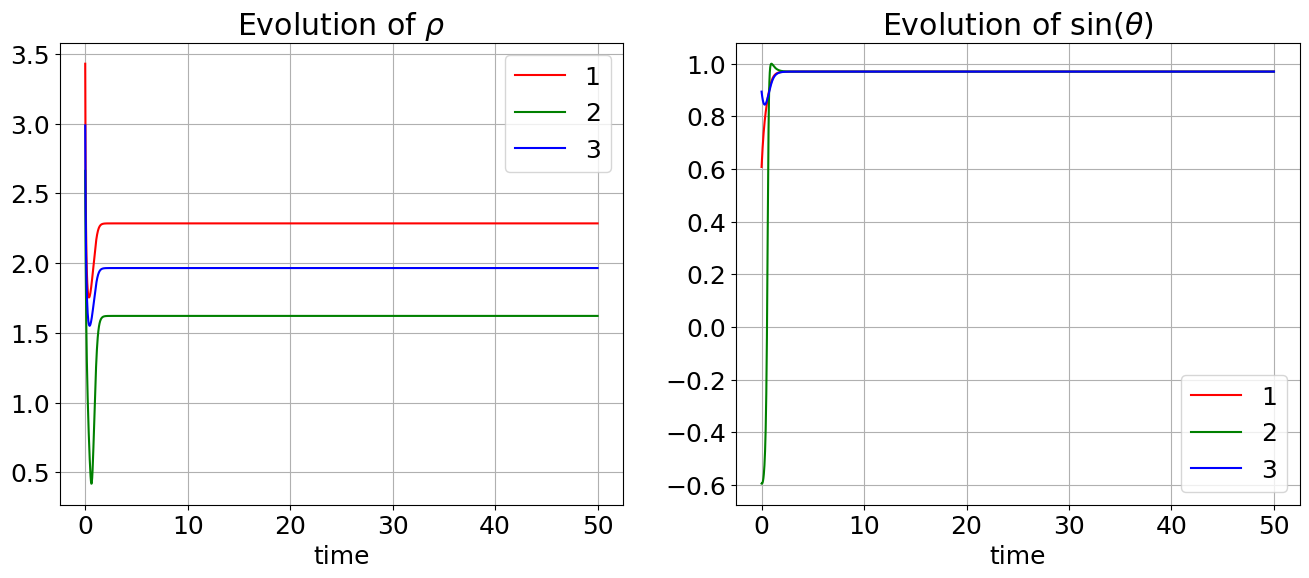

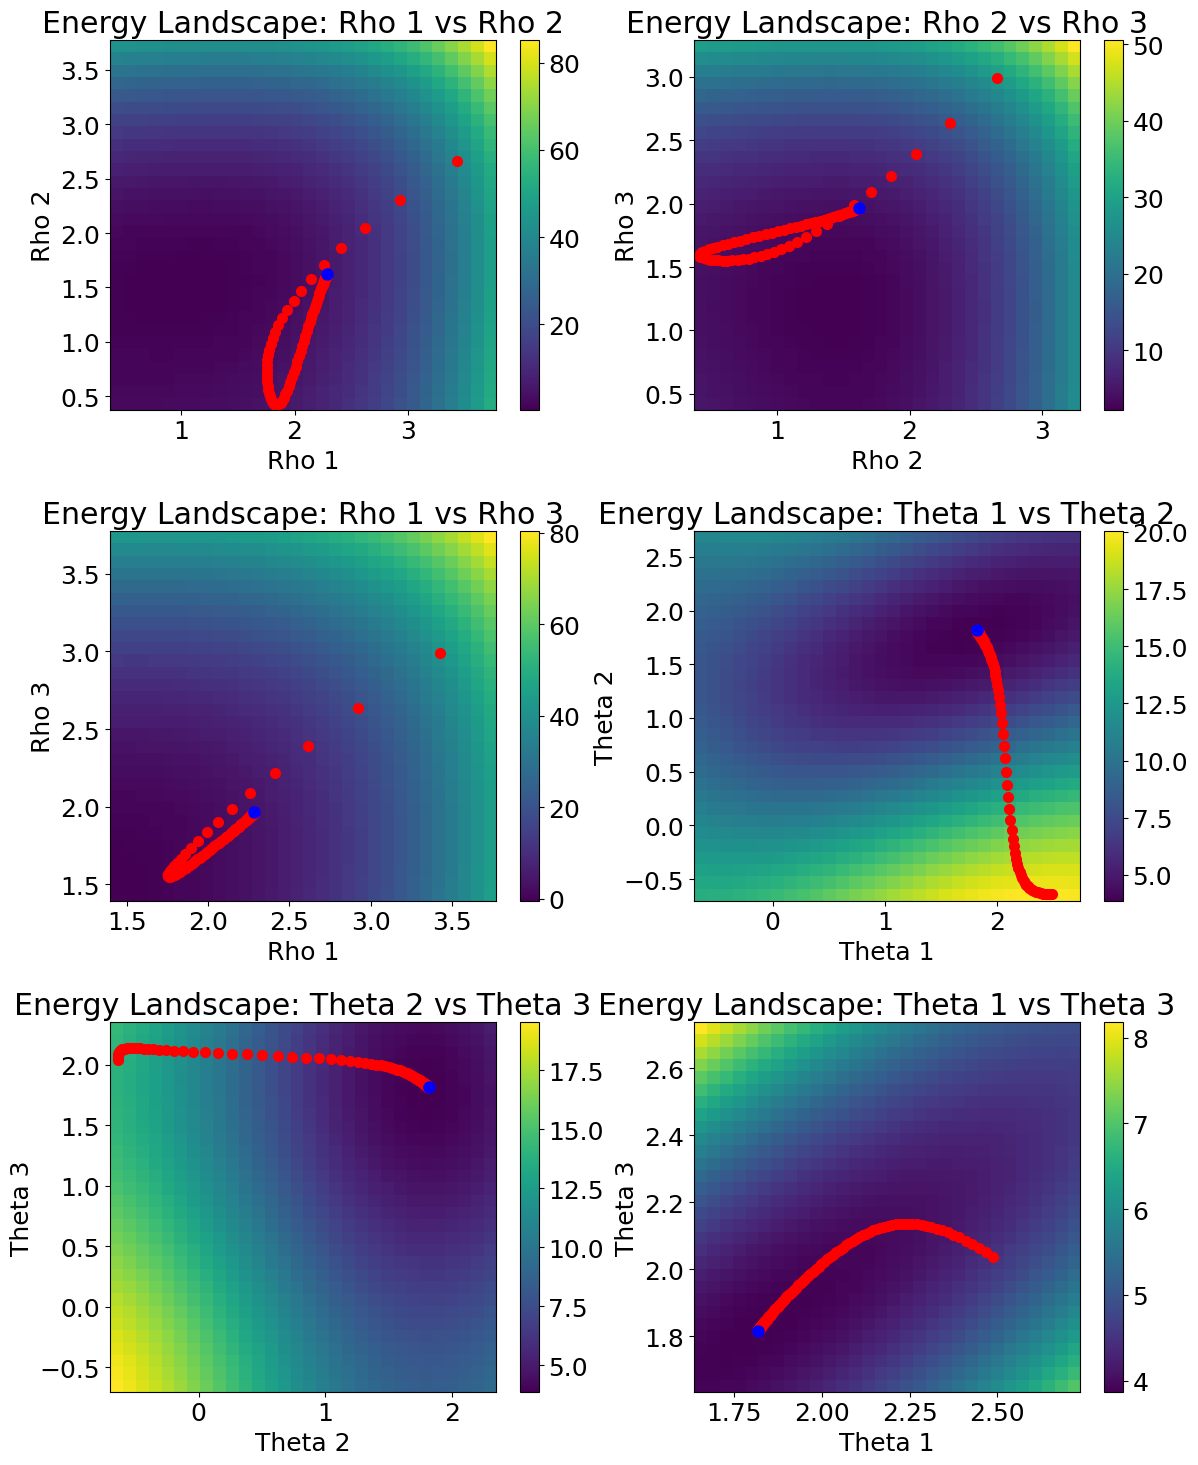

KeyboardInterrupt: 

In [131]:
#rho_vals = (1.1,1.2,0.9)
#theta_vals = (np.pi/3, 2.3, -1.2)
#omega_vals = (0,0,0)
omega = np.zeros(3) 
connections_neuronwise = np.array([[element for element in range(3) if element != neuron] for neuron in range(3)])
weights_matrix = np.zeros((3,3)) 
for i in range(1,3):
    for j in range(0,i):
        weights_matrix[i][j] = np.random.normal(loc=0, scale=1)
        weights_matrix[j][i] = weights_matrix[i][j]
weights = weights_matrix[connections_neuronwise, np.arange(3)[:, None]] 
W = weights_matrix
alpha = 1
drho = 0.05
dtheta = 0.05
rhomax = 1
thetamax = 1


init_densities = np.array([np.random.uniform(-1, 1)/2 for _ in range(3)]) + amplitude_relative
init_phases = np.array([np.random.uniform(-np.pi, np.pi) for _ in range(3)])
state = np.concatenate((init_densities, init_phases))
T = 50
dt = 0.02
times = np.arange(0, T+dt, dt)


solution = odeint(network_evolution, state, times, args=(weights, alpha, omega, connections_neuronwise, []), full_output=0)


fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 6)) 
colors = ['green'] * 3
colors[0] = 'red'
colors[1] = 'green'
colors[2] = 'blue'
label = ["1","2","3"]
for j in range(3):
    axes[0].plot(times, solution[:,j], color=colors[j], label=label[j])
axes[0].set_title(r"Evolution of $\rho$")
axes[0].set_xlabel("time")
axes[0].grid()
axes[0].legend()

for j in range(3):
    axes[1].plot(times, np.sin(solution[:,3+j]), color=colors[j], label=label[j])
axes[1].set_xlabel("time")
axes[1].grid()
axes[1].set_title(r"Evolution of $\sin(\theta)$")
axes[1].legend()
plt.savefig("Energy landscape evolution.svg", format='svg')
plt.show()

solution_last = solution[-1]
rho_vals = (solution_last[0], solution_last[1], solution_last[2])
theta_vals = (solution_last[3], solution_last[4], solution_last[5])
omega_vals = (omega[0],omega[1],omega[2])

show_energy_landscape(solution, omega_vals, W, alpha, 30, "Energy landscape.svg")
show_energy_landscape_3D(solution, omega_vals, W, alpha, 20, "Energy landscape.svg")
#show_energy_landscape_3d(rho_vals, theta_vals, omega_vals, W, alpha, drho, rhomax, dtheta, thetamax, "Energy landscape_3D.png", trajectory=solution)





In [125]:
"duduś.svg"[-3:]

'svg'

In [ ]:
"""
for _ in [0,1]:
    distances_amp, accuracies = run_from_nothing(N=6, number_of_epochs=1000, learning_rate=0.01, do_normalize=True, do_debug=False, connections_neuronwise=None, amplitude_relative=1., randomization=1)
    save_array_to_file(np.array(distances_amp), "XOR_6_neurons_1000_epochs_0.01_eta_random_1.txt")
    save_array_to_file(np.array(accuracies), "XOR_6_neurons_1000_epochs_0.01_eta_random_1_accuracies.txt")
for _ in range(4):
    distances_amp, accuracies = run_from_nothing(N=6, number_of_epochs=100, learning_rate=0.1, do_normalize=True, do_debug=False, connections_neuronwise=None, amplitude_relative=1., randomization=2)
    save_array_to_file(np.array(distances_amp), "XOR_6_neurons_100_epochs_random_2.txt")
    save_array_to_file(np.array(distances_amp), "XOR_6_neurons_100_epochs_random_2_accuracies.txt")
for _ in range(4):
    distances_amp, accuracies = run_from_nothing(N=6, number_of_epochs=100, learning_rate=0.1, do_normalize=True, do_debug=False, connections_neuronwise=None, amplitude_relative=1., randomization=4)
    save_array_to_file(np.array(distances_amp), "XOR_6_neurons_100_epochs_random_4.txt")
    save_array_to_file(np.array(distances_amp), "XOR_6_neurons_100_epochs_random_4_accuracies.txt")
for _ in range(4):
    distances_amp, accuracies = run_from_nothing(N=6, number_of_epochs=100, learning_rate=0.1, do_normalize=True, do_debug=False, connections_neuronwise=None, amplitude_relative=1., randomization=6)
    save_array_to_file(np.array(distances_amp), "XOR_6_neurons_100_epochs_random_6.txt")
    save_array_to_file(np.array(distances_amp), "XOR_6_neurons_100_epochs_random_6_accuracies.txt")
"""

In [96]:
def calculate_average_slope_from_file(filename="savepoint.txt"):
    """
    Calculates the average slope of all arrays stored line-by-line in a file.
    
    Each line in the file is assumed to be a flattened numpy array.
    """
    slopes = []
    
    with open(filename, "r") as file:
        for line in file:
            # Convert each line into a numpy array of floats
            array = np.array(list(map(float, line.split())))
            
            # Calculate the slope for this array
            if len(array) > 1:  # Ensure the array has at least two points
                differences = np.diff(array)  # Get differences between successive elements
                mean_slope = differences.mean()  # Mean slope for this array
                slopes.append(mean_slope)
    
    # Calculate the average slope across all arrays
    return np.mean(slopes) if slopes else 0  # Return 0 if no slopes were found

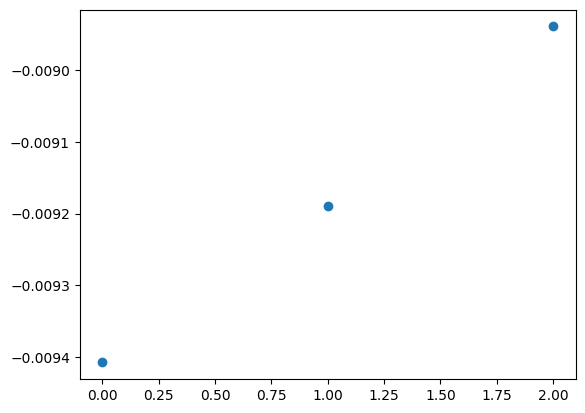

In [100]:
average_slope_random_2 = calculate_average_slope_from_file("XOR_6_neurons_100_epochs_random_2.txt")
average_slope_random_4 = calculate_average_slope_from_file("XOR_6_neurons_100_epochs_random_4.txt")
average_slope_random_6 = calculate_average_slope_from_file("XOR_6_neurons_100_epochs_random_6.txt")

y = np.array([average_slope_random_2,average_slope_random_4,average_slope_random_6])
x = np.linspace(0,2,3)
plt.scatter(x,y)
plt.show()

The effective y-axis maximum is set to: 1.795778235667632
Figure saved as: 5 neurons distances.png


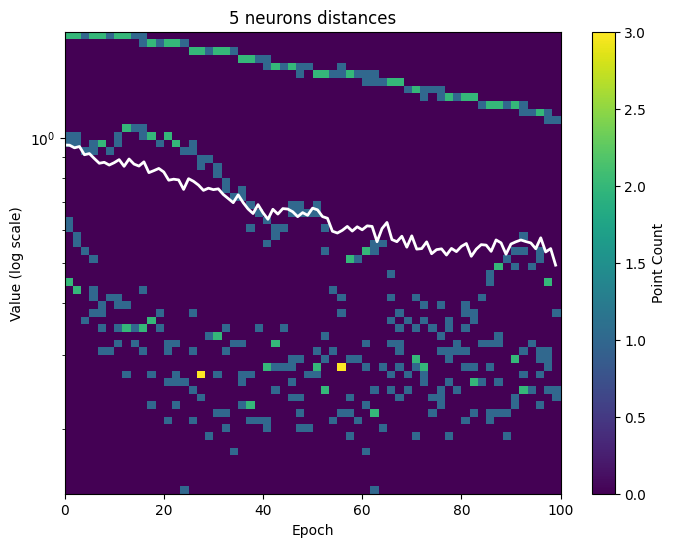

The effective y-axis maximum is set to: 0.6651594524224431
Figure saved as: 5 neurons distances.png


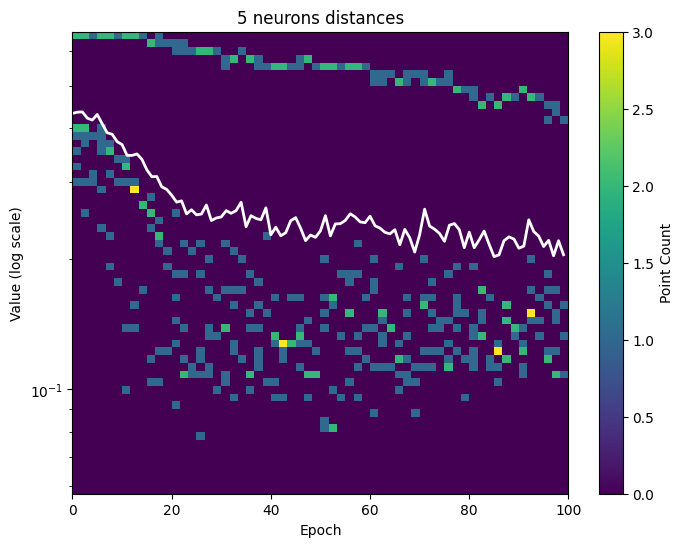

The effective y-axis maximum is set to: 0.4901462097898644
Figure saved as: 5 neurons distances.png


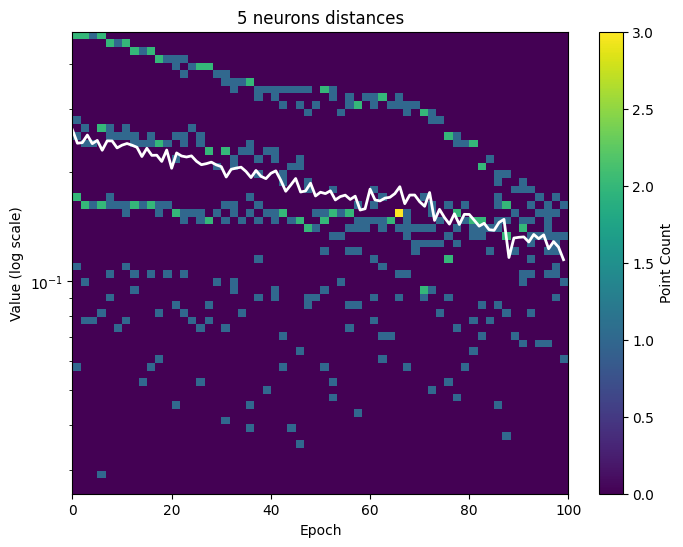

In [106]:
read_and_plot_log("XOR_6_neurons_100_epochs_random_2.txt", y_bins=60, x_bins=60, plot_title="6 neurons distances",multiplicator=1/2)
#read_and_plot("XOR_6_neurons_100_epochs_random_2_accuracies.txt", y_bins=10, x_bins=40, plot_title="5 neurons, accuracies")
read_and_plot_log("XOR_6_neurons_100_epochs_random_4.txt", y_bins=60, x_bins=60, plot_title="6 neurons distances",multiplicator=1/4)
#read_and_plot("XOR_6_neurons_100_epochs_random_4_accuracies.txt", y_bins=10, x_bins=40, plot_title="5 neurons, accuracies")
read_and_plot_log("XOR_6_neurons_100_epochs_random_6.txt", y_bins=60, x_bins=60, plot_title="6 neurons distances",multiplicator=1/6)
#read_and_plot("XOR_6_neurons_100_epochs_random_6_accuracies.txt", y_bins=10, x_bins=40, plot_title="5 neurons, accuracies")